In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import math
import random
from scipy.optimize import curve_fit
import warnings
from statsummary import summarizeAsString

In [16]:
data = pd.read_csv("COVIDStates.csv")

In [17]:
data = data[data["state"] != "District of Columbia"]
data = data[data["state"] != "Guam"]
data = data[data["state"] != "Northern Mariana Islands"]
data = data[data["state"] != "Puerto Rico"]
data = data[data["state"] != "Virgin Islands"]

In [18]:
states = np.unique(data["state"])

In [19]:
populations = pd.read_csv("StatePopulations.csv")

In [20]:
def getFrame(d, state):
    data = d.copy()
    return data[data["state"] == state]

In [21]:
def newCases(d):
    data = d.copy()
    last = 0
    new = []
    for index, row in data.iterrows():
        new.append(row["cases"] - last)
        last = row["cases"]
    return new

In [22]:
def normalize(data, pop):
    normalized = []
    for index, row in data.iterrows():
        normalized.append(row["newCases"]/pop)
    return normalized

In [23]:
def gaussian(x, a, b, c):
    return a*np.exp(-np.power(x - b, 2)/(2*np.power(c, 2)))

In [24]:
def fit(data):
    params = [random.random()*100, random.random()*100, random.random()*100]
    x = np.linspace(0, len(data["date"]), len(data["date"]))
    y = gaussian(x, params[0], params[1], params[2])
    pars, cov = curve_fit(f=gaussian, xdata=x, ydata=data["newCases"], p0=params, bounds=(-np.inf, np.inf), maxfev = 1000000)
    y_fit = gaussian(x, *pars)
    return y_fit

In [25]:
def pop(state):
    return int(populations[populations["State"] == state]["Population"])

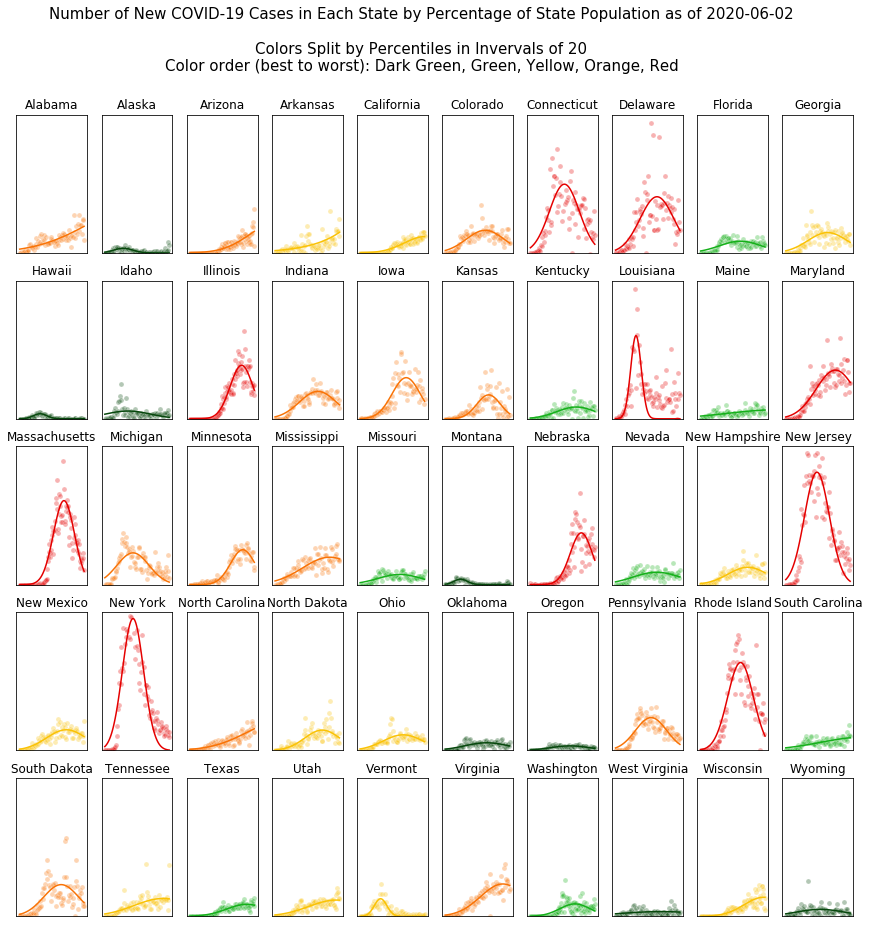

In [26]:
plt.rcParams["figure.figsize"] = (15, 30)

peaks = []

for i in range(math.floor(len(states))):
    
    frame = getFrame(data, states[i])
    frame["newCases"] = newCases(frame)
    
    err = True
    while err == True:
        try:
            y_fit = fit(frame)

            for j in y_fit:
                if j > 1:
                    err = False
                    break
        except:
            pass
        
    frame["newCases"] = normalize(frame, pop(states[i]))
    y_fit = y_fit/pop(states[i])
    peaks.append(max(y_fit))
    
    if max(y_fit) <= 2.8156851096244495e-05:
        color = "xkcd:forest green"
    elif max(y_fit) <= 4.960241926837847e-05:
        color = "xkcd:green"
    elif max(y_fit) <= 7.57820769157415e-05:
        color = "xkcd:goldenrod"
    elif max(y_fit) <= 0.00016265423132073005:
        color = "xkcd:orange"
    else:
        color = "xkcd:red"
            
    plt.subplot(10, 10, i+1)
    sns.scatterplot(frame["date"], frame["newCases"], alpha = 0.3, s = 25, color = color)
    sns.lineplot(frame["date"], y_fit, color = color)
    
    plt.ylim(0, .0005)
    
    plt.yticks([])
    plt.xticks([])
    plt.xlabel("")
    plt.ylabel("")
    plt.title(states[i])
    
plt.suptitle("Number of New COVID-19 Cases in Each State by Percentage of State Population as of " + list(data["date"])[len(data["date"])-1] + "\n\nColors Split by Percentiles in Invervals of 20\nColor order (best to worst): Dark Green, Green, Yellow, Orange, Red", y = .93, fontsize = 15)
    
#print(np.percentile(peaks, 20))
#print(np.percentile(peaks, 40))
#print(np.percentile(peaks, 60))
#print(np.percentile(peaks, 80))

plt.savefig("AllStates.png", bbox_inches = "tight")